# Time Series Forecasting Using Recurrent Neural Networks

In [1]:
import pandas as pd
from pathlib import Path

## Loading the data

In [2]:
df = pd.read_csv(r"C:\Users\arnol\Desktop\datasets\CTA_-_Ridership_-_Daily_Boarding_Totals.csv", parse_dates=["service_date"])
df.head(5)

,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343


In [3]:
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()
df.head(5)

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


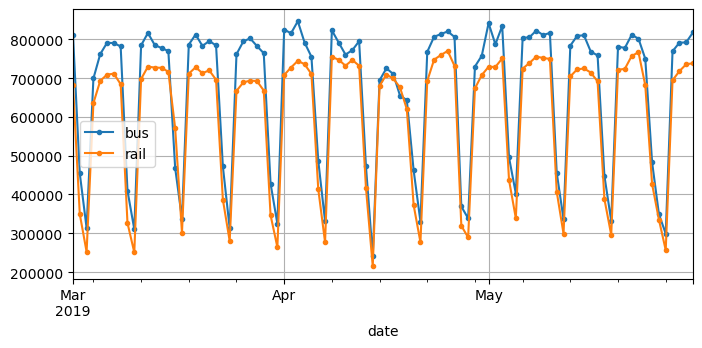

In [4]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

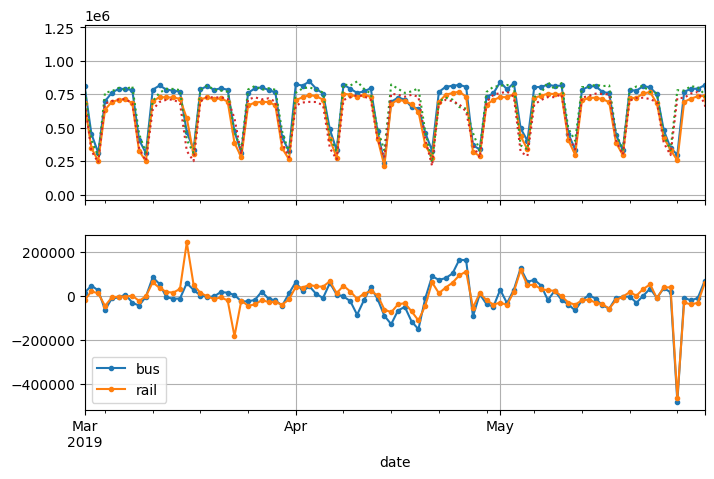

In [9]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".") # original time
df.shift(7).plot(ax=axs[0], grid=True, legend=False,
linestyle=":") # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".") # 7-day difference
plt.show()

## MAE of Naive forecast

In [10]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

## Mean absolute percentage error

In [11]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]

In [12]:
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()

In [17]:
y_pred = model.forecast()
y_pred

2019-06-01    427758.626286
Freq: D, dtype: float64

In [21]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []

for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    
    # Fix: Use .iloc to access by position instead of [0]
    forecast_result = model.forecast(steps=1)
    y_pred = forecast_result.iloc[0]  # This is the proper way to access by position
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [22]:
mae

32040.720102669347

## Preparing the Data for Machine Learning Models

In [23]:
import tensorflow as tf

### Splitting and scaling the data

In [24]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [25]:
seq_length = 56

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets = rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## Forecasting Using Linear Model

In [27]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True
)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

In [28]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0512 - mae: 0.2587 - val_loss: 0.0141 - val_mae: 0.1387
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - mae: 0.1126 - val_loss: 0.0075 - val_mae: 0.0898
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - mae: 0.0918 - val_loss: 0.0070 - val_mae: 0.0845
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - mae: 0.0893 - val_loss: 0.0063 - val_mae: 0.0789
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - mae: 0.0976 - val_loss: 0.0061 - val_mae: 0.0780
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0833 - val_loss: 0.0059 - val_mae: 0.0783
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0763 - val_loss: 0.0055 - val_mae: 0.0746
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0773 - val_loss: 0.0051 - val_mae: 0.0705
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

## Forecasting Using a Deep Recurrent Network

In [30]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [31]:
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

In [32]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0978 - mae: 0.3902 - val_loss: 0.0145 - val_mae: 0.1171
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - mae: 0.1250 - val_loss: 0.0126 - val_mae: 0.1190
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0124 - mae: 0.1360 - val_loss: 0.0121 - val_mae: 0.1245
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0124 - mae: 0.1367 - val_loss: 0.0121 - val_mae: 0.1224
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - mae: 0.1399 - val_loss: 0.0121 - val_mae: 0.1215
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0119 - mae: 0.1318 - val_loss: 0.0120 - val_mae: 0.1223
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - mae: 0.1332 - val_loss: 0.0119 - val_mae: 0.1216
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0118 - mae: 0.1322 - val_loss: 0.0119 - val_mae: 0.1211
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo